# Data Modeling 02: Prophet, and Capturing Seasonality

So far, we've worked with very classic, at least in the terms of competitive data science, models. In the first modeling notebook, we made several baseline models as well as a tuned XGBoost model. Although both the linear models and XGBoost were able to capture seasonality, they were not able to catch upward and irregular trends. 

In this notebook, I will try and capture more seasonality and trend by using Facebook Prophet, a fourier based model that accounts for seasonality at various time lags and levels.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px

import sklearn as sk
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
import tensorflow as tf

In [2]:
df = pd.read_csv('../data/clean/full/dengue_features_train.csv')
df_labels = pd.read_csv('../data/clean/full/dengue_labels_train.csv')
df_test = pd.read_csv('../data/raw/dengue_features_test.csv')

sj_features = pd.read_csv('../data/clean/sj/sj_train_features.csv')
sj_labels = pd.read_csv('../data/clean/sj/sj_train_labels.csv')

iq_features = pd.read_csv('../data/clean/iq/iq_train_features.csv')
iq_labels = pd.read_csv('../data/clean/iq/iq_train_labels.csv')

sj_test = pd.read_csv('../data/clean/sj/sj_test_features.csv')
iq_test = pd.read_csv('../data/clean/iq/iq_test_features.csv')

Let's explore the dataset with Facebook prophet. This is a model commonly fit to seemingly seasonal or cyclical trends. More information can be found [here](https://facebook.github.io/prophet/).

It requires a special dataset, that is, one where the two columns are `[time, y]`

In [3]:
def gen_prophet_df(features: pd.DataFrame(), labels: pd.DataFrame()) -> pd.DataFrame:
    df = pd.DataFrame()
    df['ds'] = pd.to_datetime(features['week_start_date'])
    df['y'] = labels['total_cases']
    return df

df_sj_prophet = gen_prophet_df(sj_features, sj_labels)
df_iq_prophet = gen_prophet_df(iq_features, iq_labels)

df_sj_prophet_test = pd.to_datetime(sj_test['week_start_date']).to_frame().rename(columns={'week_start_date':'ds'})
df_iq_prophet_test = pd.to_datetime(iq_test['week_start_date']).to_frame().rename(columns={'week_start_date':'ds'})

Now, we will build seperate models for each city, as our data exploration implied their isn't much correlation between cases. Additionally, all of our models have performed better on the leaderboard when trained on the cities seperately, implying there isn't much to learn about possible correlations between them.

First, start with SJ

In [29]:
sj_m = Prophet(
    growth = 'linear',
    yearly_seasonality = 10,
    weekly_seasonality = False,
    daily_seasonality = False,
    seasonality_mode = 'multiplicative'
)

Now, let's train each of them and visualize their results and CV scores before making a submission

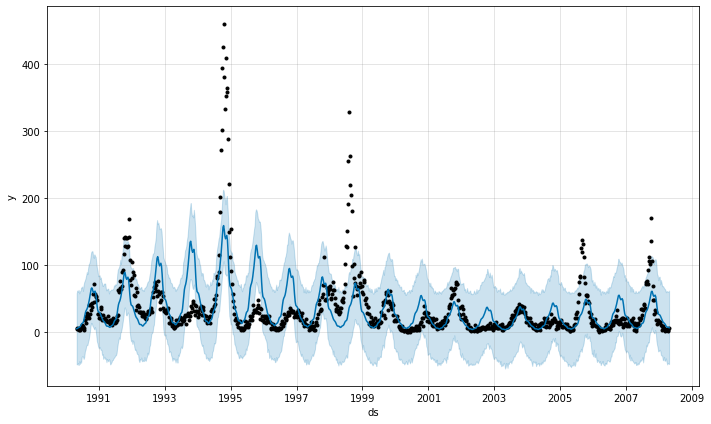

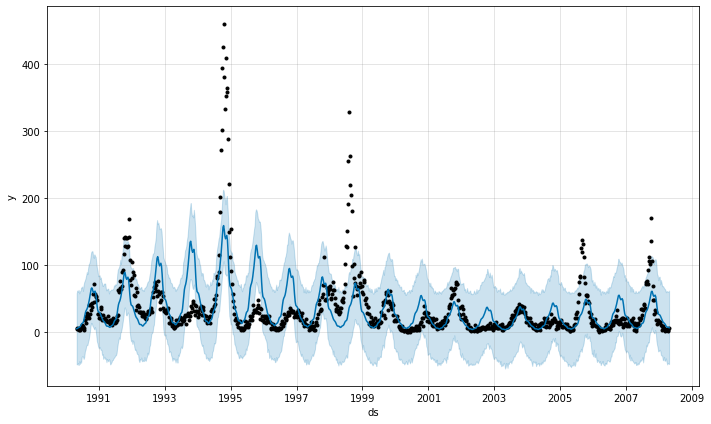

In [30]:
sj_m.fit(df_sj_prophet)
forcast_sj = sj_m.predict(df_sj_prophet)
sj_m.plot(forcast_sj)

In [33]:
cv_sj = cross_validation(sj_m, horizon = '730 days')
mean_absolute_error(cv_sj['yhat'], cv_sj['y'])

INFO:fbprophet:Making 10 forecasts with cutoffs between 1997-04-25 00:00:00 and 2006-04-23 00:00:00


26.493915768767973

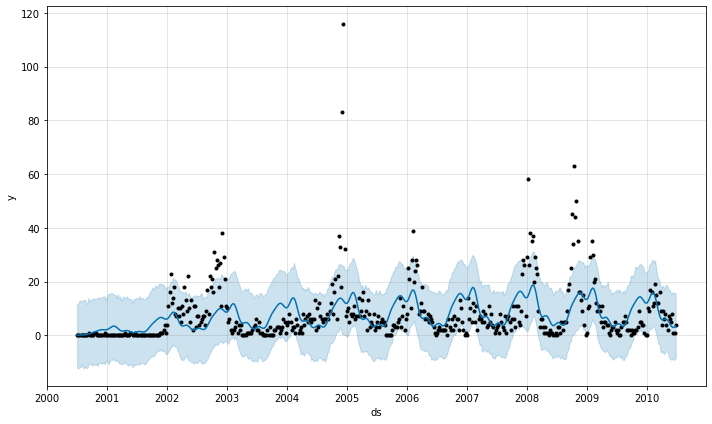

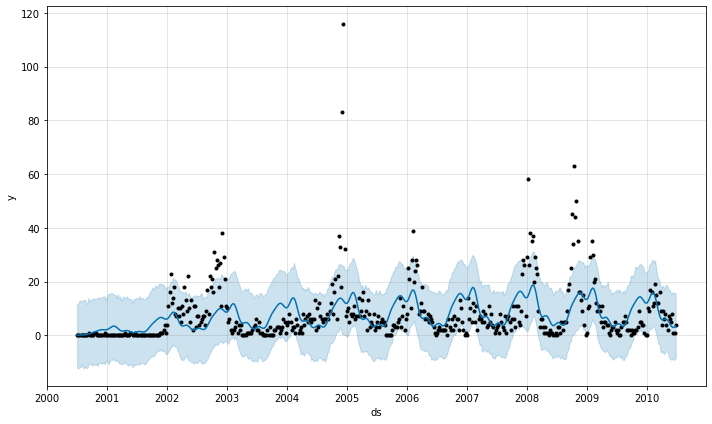

In [34]:
iq_m.fit(df_iq_prophet)
forcast_iq = iq_m.predict(df_iq_prophet)
iq_m.plot(forcast_iq)

In [35]:
cv_iq = cross_validation(iq_m, horizon = '730 days')
mean_absolute_error(cv_iq['yhat'], cv_iq['y'])

INFO:fbprophet:Making 2 forecasts with cutoffs between 2007-06-26 00:00:00 and 2008-06-25 00:00:00


9.752910956113272

## Test data
Now, let's predict the test data and make a submission to see where we stand.

In [39]:
sj_p = sj_m.predict(df_sj_prophet_test)['yhat'].values
iq_p = iq_m.predict(df_iq_prophet_test)['yhat'].values

preds = np.rint(np.concatenate((sj_p, iq_p)))

In [40]:
subm = pd.read_csv('../data/raw/submission_format.csv')
subm['total_cases'] = preds.astype(int)
subm.to_csv('../subm5.csv', index=False)

This gets our leaderboard MAE down to **25.4591**, placing us in the top **11.8%** of contestants.

## Random hyperparameter search

Prophet has a lot of parameters, so an exhuastive grid search is not realistic if we want to try out many models -- especially with the high training time. So instead, let's define a list of parameters to try, and then CV models trained on a random subset of them. 

In [ ]:
growth = ['linear']
changepoint_prior_scale = [0.001, 0.5, 1]
yearly_seasonality = [1, 5, 10, 15]
monthly_seasonality = [5, 10]
seasonality_mode = ['multiplicative', 'additive']

def prophet_random_search(n: int, df: pd.DataFrame):
    for i in range(n-1):
        m = Prophet(
            weekly_seasonality = False,
            daily_seasonality = False,
            yearly_seasonality = True,
            # random params
            growth = np.random.choice(growth),
            changepoint_prior_scale = np.random.choice(changepoint_prior_scale),
            seasonality_mode= np.random.choice(seasonality_mode),
        )
        m.fit(df)
        cv = cross_validation(m, horizon = '730 days')
        print(mean_absolute_error(cv['yhat'], cv['y']))
        print(m.changepoint_prior_scale, m.yearly_seasonality, m.seasonality_mode)

def prophet_grid_search(df: pd.DataFrame):
    pass
prophet_random_search(5, df_sj_prophet)

INFO:fbprophet:Making 10 forecasts with cutoffs between 1997-04-25 00:00:00 and 2006-04-23 00:00:00
INFO:fbprophet:Making 10 forecasts with cutoffs between 1997-04-25 00:00:00 and 2006-04-23 00:00:00


46.10944440998789
1.0 True multiplicative


Improving random search